In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve()
while ROOT != ROOT.parent and not (ROOT / "data").exists():
    ROOT = ROOT.parent

SAMPLE = ROOT / "data" / "gold" / "samples" / "bicing_gold_final_plus_sample_1M_strat_holidays.parquet"
df = pq.read_table(SAMPLE).to_pandas()

df["time_hour"] = pd.to_datetime(df["time_hour"])
df["date"] = pd.to_datetime(df["date"])

# holiday_any consistente (no dependas de is_holiday legacy)
df["holiday_any"] = (
    (df["is_holiday_barcelona"] == 1) |
    (df["is_holiday_catalunya"] == 1) |
    (df["is_holiday_spain"] == 1)
).astype(int)

df["holiday_scope_final"] = df["holiday_scope"].fillna("none")

print("shape:", df.shape)
print("range:", df["time_hour"].min(), "->", df["time_hour"].max())
print(df["holiday_scope_final"].value_counts())


shape: (1000000, 29)
range: 2019-03-28 18:00:00 -> 2025-12-31 23:00:00
holiday_scope_final
none         700000
spain        166356
catalunya     93212
barcelona     40432
Name: count, dtype: int64


In [2]:
df["capacity_mean"] = df["bikes_available_mean"] + df["docks_available_mean"]
bad = (df["bikes_available_mean"] > df["capacity_mean"]).sum()
zero_cap = (df["capacity_mean"] <= 0).sum()

print("capacity <=0:", zero_cap)
print("bikes > capacity:", bad)

df["occ_ratio"] = np.where(df["capacity_mean"] > 0, df["bikes_available_mean"] / df["capacity_mean"], np.nan)
print(df["occ_ratio"].describe())


capacity <=0: 389
bikes > capacity: 0
count    999611.000000
mean          0.382248
std           0.289783
min          -0.013575
25%           0.122977
50%           0.333333
75%           0.600000
max           1.000000
Name: occ_ratio, dtype: float64


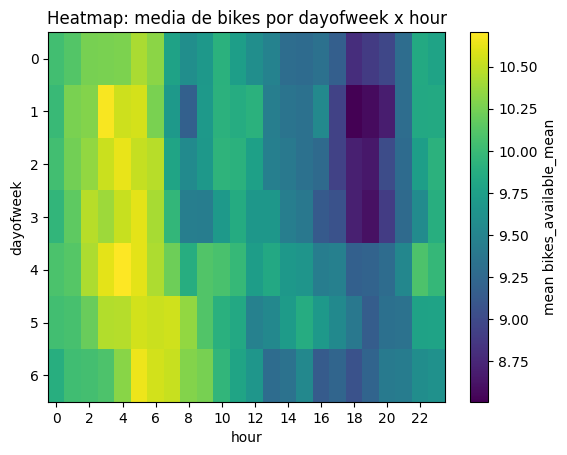

In [3]:
pivot = df.pivot_table(
    index="dayofweek", columns="hour",
    values="bikes_available_mean", aggfunc="mean"
).sort_index()

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="mean bikes_available_mean")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(0, 24, 2), list(range(0, 24, 2)))
plt.title("Heatmap: media de bikes por dayofweek x hour")
plt.xlabel("hour")
plt.ylabel("dayofweek")
plt.show()


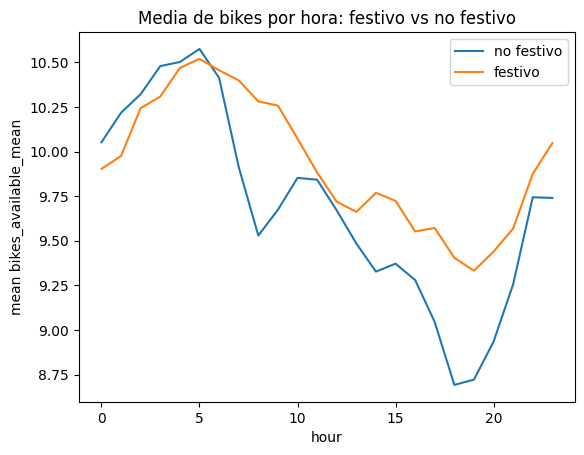

In [4]:
g = df.groupby(["hour", "holiday_any"])["bikes_available_mean"].mean().reset_index()
h0 = g[g["holiday_any"] == 0].set_index("hour")["bikes_available_mean"]
h1 = g[g["holiday_any"] == 1].set_index("hour")["bikes_available_mean"]

plt.figure()
plt.plot(h0.index, h0.values, label="no festivo")
plt.plot(h1.index, h1.values, label="festivo")
plt.title("Media de bikes por hora: festivo vs no festivo")
plt.xlabel("hour")
plt.ylabel("mean bikes_available_mean")
plt.legend()
plt.show()


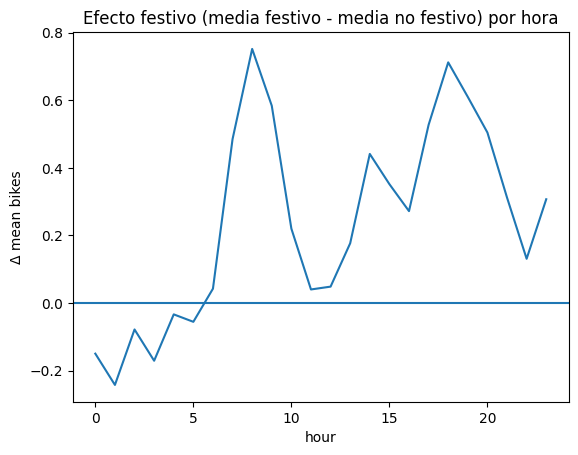

In [5]:
g = df.groupby(["hour", "holiday_any"])["bikes_available_mean"].mean().unstack()
g["diff_holiday_minus_no"] = g[1] - g[0]

plt.figure()
plt.plot(g.index, g["diff_holiday_minus_no"].values)
plt.axhline(0)
plt.title("Efecto festivo (media festivo - media no festivo) por hora")
plt.xlabel("hour")
plt.ylabel("Δ mean bikes")
plt.show()



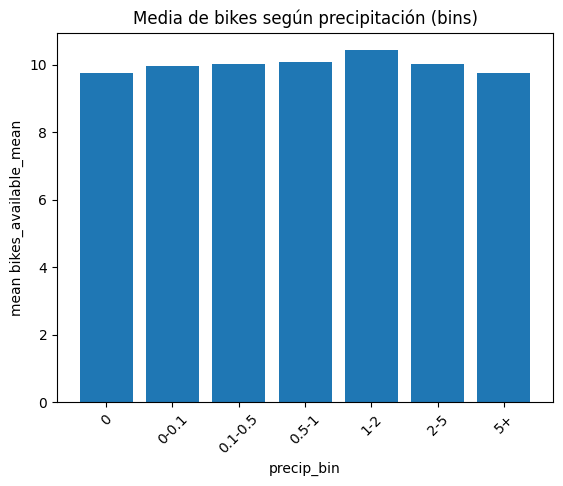

In [6]:
bins = [-0.001, 0, 0.1, 0.5, 1, 2, 5, 100]
labels = ["0", "0-0.1", "0.1-0.5", "0.5-1", "1-2", "2-5", "5+"]

df["precip_bin"] = pd.cut(df["precipitation"], bins=bins, labels=labels)
b = df.groupby("precip_bin")["bikes_available_mean"].mean()

plt.figure()
plt.bar(b.index.astype(str), b.values)
plt.title("Media de bikes según precipitación (bins)")
plt.xlabel("precip_bin")
plt.ylabel("mean bikes_available_mean")
plt.xticks(rotation=45)
plt.show()


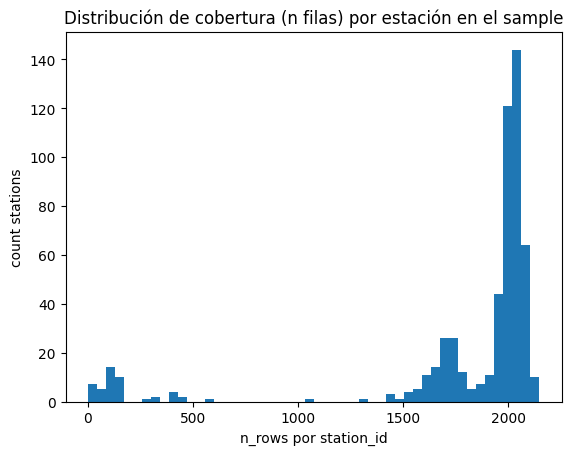

count     556.000000
mean     1798.561151
std       515.642416
min         1.000000
25%      1762.750000
50%      2000.500000
75%      2039.000000
max      2147.000000
Name: time_hour, dtype: float64
Top 5 estaciones con menos cobertura:
 station_id
521    1
532    1
536    3
543    4
542    6
Name: time_hour, dtype: int64


In [7]:
cov = df.groupby("station_id")["time_hour"].count()

plt.figure()
plt.hist(cov.values, bins=50)
plt.title("Distribución de cobertura (n filas) por estación en el sample")
plt.xlabel("n_rows por station_id")
plt.ylabel("count stations")
plt.show()

print(cov.describe())
print("Top 5 estaciones con menos cobertura:\n", cov.sort_values().head())


In [2]:
import duckdb

p = "data/gold/bicing_gold_final_plus.parquet"
con = duckdb.connect()
df_cov = con.execute(f"""
  SELECT station_id, COUNT(*) AS n_rows
  FROM read_parquet('{p}')
  GROUP BY 1
  ORDER BY n_rows
""").df()
con.close()

print(df_cov.head(15))
print(df_cov.describe())


IOException: IO Error: No files found that match the pattern "data/gold/bicing_gold_final_plus.parquet"

LINE 3:   FROM read_parquet('data/gold/bicing_gold_final_plus.parquet')
               ^